![Banner](img/AI_Special_Program_Banner.jpg)

## Introduction to (Vision) Transformer Models - Material
---

Transformer Models have revolutionized the field of machine learning, offering versatile architectures that excel in understanding complex patterns in data. Initially conceived for natural language processing tasks, Transformer Models are expanding their influence into other domains, including computer vision. These models are characterized by their unique ability to process sequential data, making them ideal for tasks involving time series, text, and even images.

In this notebook, we will explore the fundamentals of Transformer Models, focusing on their adaptability and efficiency in handling different types of data. We will use Vision Transformer Models as a specific case study to demonstrate how these powerful architectures can be adapted from language to vision tasks. Vision Transformers represent an intriguing adaptation of the Transformer framework, treating image patches as sequential tokens, thus allowing the model to capture complex spatial hierarchies and relationships within visual data.

Our practical exploration will be grounded in the Flickr8K dataset, available on [Kaggle](https://www.kaggle.com/datasets/sayanf/flickr8k/data). This dataset comprises 8,000 images, each accompanied by five different captions. These captions provide diverse insights into the content of the images, making the dataset an excellent resource for training and evaluating image captioning models.

The material presented is adapted from the course *Hands on NLP with Transformers* by O’Reilly. Complete source code is available on [GitHub](https://github.com/sinanuozdemir/oreilly-hands-on-transformers).

## Overview
- [Fine-tuning an Image Captioning System: Preparations](#Fine-tuning-an-Image-Captioning-System:-Preparations)
- [Fine-tuning an Image Captioning System: Training](#Fine-tuning-an-Image-Captioning-System:-Training)
- [Fine-tuning an Image Captioning System: Inference](#Fine-tuning-an-Image-Captioning-System:-Inference)

## Fine-tuning an Image Captioning System: Preparations

In [1]:
# More information on the used transformers library can be found here: https://huggingface.co/docs/transformers/index
from transformers import VisionEncoderDecoderModel, GPT2TokenizerFast, AutoProcessor, AutoTokenizer, TrainingArguments, Trainer, ViTModel

from sklearn.feature_extraction.text import CountVectorizer
from PIL import Image
import os
import matplotlib.pyplot as plt
import numpy as np
from datasets import Dataset
import torch
from torch import numel
import numpy as np
from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor, Resize, RandomHorizontalFlip
import pandas as pd

import requests
from io import BytesIO
import warnings
warnings.filterwarnings('ignore')

In [2]:
print(f"Number of GPUs available: {torch.cuda.device_count()}")

for i in range(torch.cuda.device_count()):
    print(torch.cuda.get_device_name(i))

Number of GPUs available: 2
NVIDIA GeForce RTX 3090
NVIDIA GeForce RTX 3090


First, let us load a pretrained Vision Transformer Encoder from [Huggingface](https://huggingface.co/google/vit-base-patch16-224-in21k):

In [3]:
VIT_MODEL = 'google/vit-base-patch16-224-in21k'
vit_model = ViTModel.from_pretrained(VIT_MODEL)

In [4]:
# Having a look at the model architecture (if you dare)
# vit_model

We need to pay attention to how images are preprocessed to match how the model was pretrained as closely as possible when doing fine-tuning:

In [5]:
feature_extractor = AutoProcessor.from_pretrained(VIT_MODEL)
feature_extractor

ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [6]:
feature_extractor.size

{'height': 224, 'width': 224}

Let's apply the pre-defined processing tasks onto our image data:

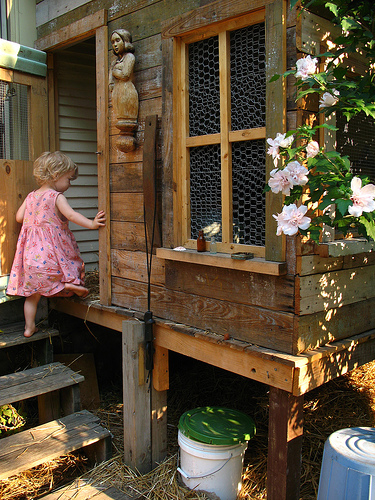

In [7]:
image_path = 'data/Flickr8k/1000268201_693b08cb0e.jpg'
img = Image.open(image_path)
display(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


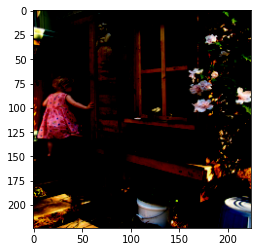

In [8]:
plt.imshow(feature_extractor(img).pixel_values[0].transpose(1, 2, 0))

In [9]:
VisionEncoderDecoderModel

transformers.models.vision_encoder_decoder.modeling_vision_encoder_decoder.VisionEncoderDecoderModel

To build an image captioning system, we not only need visual encoding for our images, but also text decoding. We will initialize our Transformer Model (Encoder/Decoder-Model) by utilizing a [Huggingface](https://huggingface.co/distilgpt2) decoder model.
During this process, many weights are innitialized randomly, namely the cross attention weights. This casuses a warning message, telling us to train the entire model in order to generate captions (which we will do).

In [10]:
model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(
    'google/vit-base-patch16-224-in21k', # encoder
    'distilgpt2'                         # decoder
)

Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at distilgpt2 and are newly initialized: ['transformer.h.3.crossattention.q_attn.weight', 'transformer.h.0.crossattention.c_proj.weight', 'transformer.h.3.crossattention.c_proj.bias', 'transformer.h.4.ln_cross_attn.bias', 'transformer.h.5.crossattention.c_proj.bias', 'transformer.h.4.ln_cross_attn.weight', 'transformer.h.1.ln_cross_attn.bias', 'transformer.h.3.ln_cross_attn.bias', 'transformer.h.0.ln_cross_attn.weight', 'transformer.h.3.crossattention.c_attn.weight', 'transformer.h.2.crossattention.c_proj.bias', 'transformer.h.1.crossattention.c_proj.bias', 'transformer.h.3.crossattention.c_attn.bias', 'transformer.h.2.crossattention.q_attn.bias', 'transformer.h.5.crossattention.c_proj.weight', 'transformer.h.2.crossattention.c_attn.weight', 'transformer.h.3.ln_cross_attn.weight', 'transformer.h.1.crossattention.c_attn.bias', 'transformer.h.3.crossattention.q_attn.bias', 'transformer.h.4.crossattention.c_att

In [11]:
type(model.encoder)

transformers.models.vit.modeling_vit.ViTModel

In [12]:
type(model.decoder)

transformers.models.gpt2.modeling_gpt2.GPT2LMHeadModel

In [13]:
total_params = 0
for param in model.parameters():
    total_params += numel(param)

print(f"Our model has a combined {total_params:,} parameters")

Our model has a combined 182,485,248 parameters


In [14]:
gpt2_tokenizer = GPT2TokenizerFast.from_pretrained('distilgpt2')

In [15]:
IMAGES_PATH = 'data/Flickr8k'
MIN_CAPTION, MAX_CAPTION = 2, 200  # feel free to set some input filtering on text lengths

def load_captions_data(filename):
    skipped = 0
    with open(filename) as caption_file:
        caption_data = caption_file.readlines()
        caption_mapping = {}
        text_data = []

        for line in caption_data:
            line = line.rstrip("\n")
            # Image name and captions are separated using a tab
            img_name, caption = line.split("\t")

            # Each image is repeated five times for the five different captions.
            # Each image name has a suffix `#(caption_number)`
            img_name = img_name.split("#")[0]
            img_name = os.path.join(IMAGES_PATH, img_name.strip())

            if img_name.endswith("jpg"):
                caption = caption.replace(' .', '').strip()
                tokens = caption.strip().split()
                if len(caption) < MIN_CAPTION or len(caption) > MAX_CAPTION:
                    skipped += 1
                    continue
                text_data.append(caption)

                if img_name in caption_mapping:
                    caption_mapping[img_name].append(caption)
                else:
                    caption_mapping[img_name] = [caption]
        return skipped, caption_mapping, text_data

# Load the dataset
skipped, captions_mapping, text_data = load_captions_data('data/Flickr8k.token.txt')

print(f'Skipped {skipped} captions')


Skipped 2 captions


In [16]:
len(captions_mapping)

8091

In [17]:
list(captions_mapping.items())[:1]

[('data/Flickr8k/1000268201_693b08cb0e.jpg',
  ['A child in a pink dress is climbing up a set of stairs in an entry way',
   'A girl going into a wooden building',
   'A little girl climbing into a wooden playhouse',
   'A little girl climbing the stairs to her playhouse',
   'A little girl in a pink dress going into a wooden cabin'])]

Let us also prepare some simple data augmentation:

In [18]:
normalize = Normalize(
    mean=feature_extractor.image_mean,
    std=feature_extractor.image_std
)

_transforms = Compose(
    [
        RandomResizedCrop(
            (feature_extractor.size['height'], feature_extractor.size['width']),
            scale=[.8, 1]),                                         # Data augmentation. Take a random resized crop of our image
        RandomHorizontalFlip(),                                     # occasionally flip the image to promote model generalizability
        ToTensor(),                                                 # Convert to pytorch tensor
        normalize                                                   # normalize pixel values to look like images during pre-training
    ]
)

In [19]:
gpt2_tokenizer.eos_token_id

50256

In [20]:
rows = []

# We could use multiple captions per image but we won't for now because of our data augmentation
for path, captions in captions_mapping.items():
    for caption in captions:
        rows.append({'path': path, 'caption': caption + gpt2_tokenizer.eos_token})

        # We only want one caption per image
        # break  # remove this break to alow for multiple captions per photo

image_df = pd.DataFrame(rows)

image_dataset = Dataset.from_pandas(image_df)

In [21]:
image_df.shape

(40453, 2)

In [22]:
image_df.head()

,path,caption
0,data/Flickr8k/1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,data/Flickr8k/1000268201_693b08cb0e.jpg,A girl going into a wooden building<|endoftext|>
2,data/Flickr8k/1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse...
3,data/Flickr8k/1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,data/Flickr8k/1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [23]:
gpt2_tokenizer.pad_token = gpt2_tokenizer.eos_token # eos = end of sequence

def image_preprocess(examples):
    # ViT expects pixel_values instead of input_ids
    examples['pixel_values'] = [Image.open(path) for path in examples['path']]
    # Padding tokens
    tokenized = gpt2_tokenizer(examples['caption'], padding='max_length', max_length=128, truncation=True)['input_ids']
    # Output captions
    examples['labels'] = [] # [l if l != gpt2_tokenizer.pad_token_id else -100 for l in t] for t in tokenized

    for t in tokenized:
        labels = []
        found = False
        for l in t:
            if l != gpt2_tokenizer.pad_token_id:
                labels.append(l)
            else:
                if not found:
                    found = True
                    labels.append(l)
                else:
                    labels.append(-100)
        examples['labels'].append(labels)

    # delete unused keys
    del examples['path']
    del examples['caption']
    return examples

In [24]:
image_dataset = image_dataset.train_test_split(test_size=0.1)

In [25]:
image_dataset['train'] = image_dataset['train'].map(image_preprocess, batched=True)

image_dataset['test'] = image_dataset['test'].map(image_preprocess, batched=True)

Map:   0%|          | 0/36407 [00:00<?, ? examples/s]

Map:   0%|          | 0/4046 [00:00<?, ? examples/s]

In [26]:
# each number represents a specific token id
# -100 is representitive of the padding token (end of sequence)
image_dataset['train'][0]

{'pixel_values': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=367x500 at 0x7F244D6C5B10>,
 'labels': [7081,
  287,
  38838,
  9422,
  491,
  14125,
  18045,
  656,
  262,
  5933,
  50256,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  

In [27]:
gpt2_tokenizer.decode([l for l in image_dataset['train'][0]['labels'] if l != -100], skip_special_tokens=False)

'boy in floral swim trunks jumps into the pool<|endoftext|>'

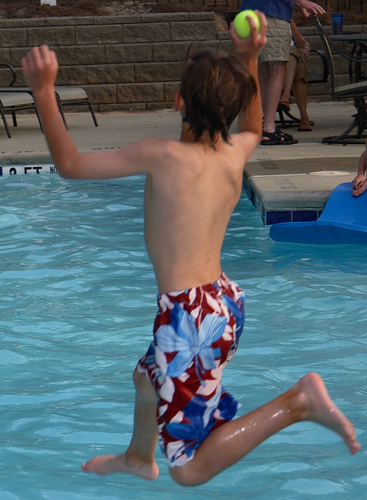

In [28]:
image_dataset['train'][0]['pixel_values']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


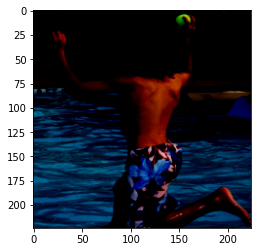

In [29]:
plt.imshow(_transforms(image_dataset['train'][0]['pixel_values']).permute(1, 2, 0))

In [30]:
image_dataset

DatasetDict({
    train: Dataset({
        features: ['pixel_values', 'labels'],
        num_rows: 36407
    })
    test: Dataset({
        features: ['pixel_values', 'labels'],
        num_rows: 4046
    })
})

In [31]:
# We set a pad token and a start token in our combined model to be the same as gpt2

model.config.pad_token = gpt2_tokenizer.pad_token
model.config.pad_token_id = gpt2_tokenizer.pad_token_id

model.config.decoder_start_token = gpt2_tokenizer.bos_token
model.config.decoder_start_token_id = gpt2_tokenizer.bos_token_id

In [32]:
def collate_fn(examples):
    pixel_values = torch.stack([_transforms(example['pixel_values']) for example in examples])
    labels = torch.tensor([example['labels'] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

## Fine-tuning an Image Captioning System: Training

<b>Please note that the following cells need to be <code>raw</code> blocks to avoid immediate execution. While training is possible, this will take a significant amount of time. Do so on your own consideration.</b>

In [33]:
training_args = TrainingArguments(
    output_dir='models/fine_tuned_transformer', # The output directory
    overwrite_output_dir=True, # overwrite the content of the output directory
    num_train_epochs=2, # number of training epochs
    per_device_train_batch_size=16, # batch size for training
    gradient_accumulation_steps=2, # gradient accumulation steps
    per_device_eval_batch_size=32,  # batch size for evaluation
    load_best_model_at_end=True,
    log_level='info',
    logging_steps=1,
    evaluation_strategy='epoch',
    save_strategy='epoch',
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=image_dataset['train'],
    eval_dataset=image_dataset['test'],
    data_collator=collate_fn
)

In [34]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 4046
  Batch size = 64


{'eval_loss': 5.157816410064697,
 'eval_runtime': 44.5968,
 'eval_samples_per_second': 90.724,
 'eval_steps_per_second': 1.435}

In [35]:
trainer.train()

***** Running training *****
  Num examples = 36,407
  Num Epochs = 2
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 2
  Total optimization steps = 1,138
  Number of trainable parameters = 182,485,248


Epoch,Training Loss,Validation Loss
1,2.628800,2.579300
2,2.548400,2.494135


***** Running Evaluation *****
  Num examples = 4046
  Batch size = 64
Saving model checkpoint to models/fine_tuned_transformer/checkpoint-569
Configuration saved in models/fine_tuned_transformer/checkpoint-569/config.json
Configuration saved in models/fine_tuned_transformer/checkpoint-569/generation_config.json
Model weights saved in models/fine_tuned_transformer/checkpoint-569/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 4046
  Batch size = 64
Saving model checkpoint to models/fine_tuned_transformer/checkpoint-1138
Configuration saved in models/fine_tuned_transformer/checkpoint-1138/config.json
Configuration saved in models/fine_tuned_transformer/checkpoint-1138/generation_config.json
Model weights saved in models/fine_tuned_transformer/checkpoint-1138/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from models/fine_tuned_transformer/checkpoint-1138 (score: 2.4941346645355225).


TrainOutput(global_step=1138, training_loss=2.708417001633736, metrics={'train_runtime': 1651.4119, 'train_samples_per_second': 44.092, 'train_steps_per_second': 0.689, 'total_flos': 9.410819316126843e+18, 'train_loss': 2.708417001633736, 'epoch': 2.0})

In [36]:
trainer.save_model()

Saving model checkpoint to models/fine_tuned_transformer
Configuration saved in models/fine_tuned_transformer/config.json
Configuration saved in models/fine_tuned_transformer/generation_config.json
Model weights saved in models/fine_tuned_transformer/pytorch_model.bin


## Fine-tuning an Image Captioning System: Inference

In [37]:
# Loading the fine-tuned model (and configuration files)
finetuned_model = VisionEncoderDecoderModel.from_pretrained('models/fine_tuned_transformer')

loading configuration file models/fine_tuned_transformer/config.json
Model config VisionEncoderDecoderConfig {
  "_commit_hash": null,
  "architectures": [
    "VisionEncoderDecoderModel"
  ],
  "decoder": {
    "_name_or_path": "distilgpt2",
    "_num_labels": 1,
    "activation_function": "gelu_new",
    "add_cross_attention": true,
    "architectures": [
      "GPT2LMHeadModel"
    ],
    "attn_pdrop": 0.1,
    "bad_words_ids": null,
    "begin_suppress_tokens": null,
    "bos_token_id": 50256,
    "chunk_size_feed_forward": 0,
    "cross_attention_hidden_size": null,
    "decoder_start_token_id": null,
    "diversity_penalty": 0.0,
    "do_sample": false,
    "early_stopping": false,
    "embd_pdrop": 0.1,
    "encoder_no_repeat_ngram_size": 0,
    "eos_token_id": 50256,
    "exponential_decay_length_penalty": null,
    "finetuning_task": null,
    "forced_bos_token_id": null,
    "forced_eos_token_id": null,
    "id2label": {
      "0": "LABEL_0"
    },
    "initializer_range": 0.

In [38]:
# Preprocessing for inference
inference_transforms = Compose(
    [
        Resize((feature_extractor.size['height'], feature_extractor.size['width'])),
        ToTensor(),
        normalize
    ]
)

In [39]:
# Helper function to caption images from the web or a file path
def caption_image(m, path):
    if 'http' in path:
        response = requests.get(path)
        img = Image.open(BytesIO(response.content))
        image_matrix = inference_transforms(img).unsqueeze(0)
    else:
        img = Image.open(path)
        image_matrix = inference_transforms(img).unsqueeze(0)

    generated = m.generate(
        image_matrix,
        num_beams=3,
        max_length=25,
        early_stopping=True,
        do_sample=True,
        top_p=.8,
        num_return_sequences=3,
        eos_token_id=gpt2_tokenizer.eos_token_id
    )

    caption_options = [gpt2_tokenizer.decode(g, skip_special_tokens=True).strip() for g in generated]
    display(img)
    return caption_options, generated, image_matrix


Let us have a look at the caption our model produces for unseen image data:

Generate config GenerationConfig {
  "_from_model_config": true,
  "decoder_start_token_id": 50256,
  "pad_token_id": 50256,
  "transformers_version": "4.30.2"
}



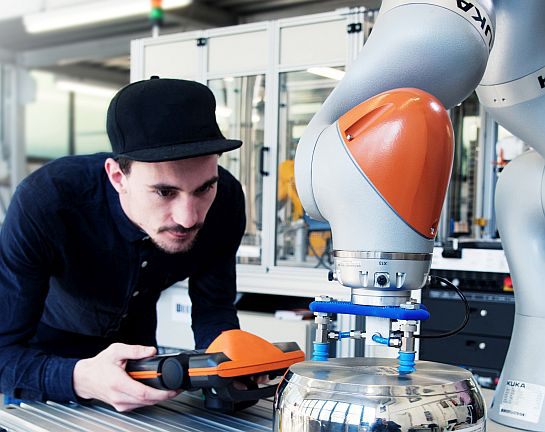

In [40]:
captions, generated, image_matrix = caption_image(finetuned_model, 'https://www.thu.de/de/HS_Bilder/Warum_Hochschule_Ulm.jpg')

In [41]:
captions

['A man in a blue jacket is sitting on a metal bench with a bucket of water',
 'A man is sitting on a wooden bench',
 'A man in a blue shirt is smoking a cigarette']

Let us also have a look at the most frequent words in our training corpus (not including stopwords):

In [42]:
vec = CountVectorizer(stop_words='english')
bag_of_words = vec.fit_transform(image_df['caption'])
sum_words = bag_of_words.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
sorted(words_freq, key = lambda x: x[1], reverse=True)[:20]

[('endoftext', 40453),
 ('dog', 8138),
 ('man', 7274),
 ('white', 3959),
 ('black', 3848),
 ('boy', 3581),
 ('woman', 3402),
 ('girl', 3328),
 ('wearing', 3062),
 ('people', 2883),
 ('water', 2790),
 ('red', 2691),
 ('young', 2630),
 ('brown', 2578),
 ('blue', 2279),
 ('dogs', 2125),
 ('running', 2073),
 ('playing', 2008),
 ('shirt', 1962),
 ('standing', 1787)]

To evaluate our model by means of quality, we can perform a sanity check: Creating captions with our fine-tuned model versus creating captions without any fine-tuning:

Generate config GenerationConfig {
  "_from_model_config": true,
  "decoder_start_token_id": 50256,
  "pad_token_id": 50256,
  "transformers_version": "4.30.2"
}



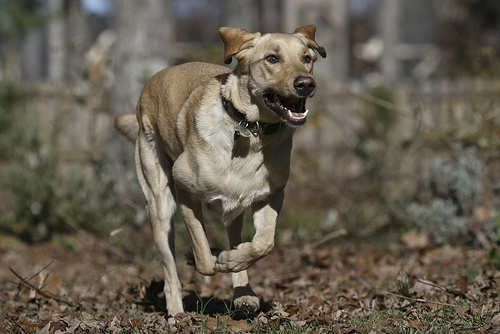

['A brown dog is running through the woods',
 'A brown dog runs through the woods',
 'A brown dog runs through the woods']

In [43]:
captions, generated, image_matrix = caption_image(finetuned_model, 'data/Flickr8k/3148647065_2d6cd88cf6.jpg')
captions

In [44]:
non_finetuned = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(
    'google/vit-base-patch16-224-in21k',
    'distilgpt2'
)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--google--vit-base-patch16-224-in21k/snapshots/7cbdb7ee3a6bcdf99dae654893f66519c480a0f8/config.json
Model config ViTConfig {
  "_name_or_path": "google/vit-base-patch16-224-in21k",
  "architectures": [
    "ViTModel"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": true,
  "transformers_version": "4.30.2"
}

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--google--vit-base-patch16-224-in21k/snapshots/7cbdb7ee3a6bcdf99dae654893f66519c480a0f8/pytorch_model.bin
All model checkpoint weights were used when initializing ViTModel.

All t

Generate config GenerationConfig {
  "_from_model_config": true,
  "transformers_version": "4.30.2"
}

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


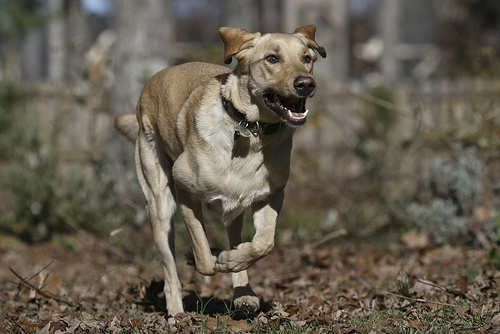

['"It\'s not going to be easy to do that," he said.',
 'The New York Times has released a new report on the Trump administration’s controversial travel ban.',
 '.']

In [45]:
captions, generated, image_matrix = caption_image(non_finetuned, 'data/Flickr8k/3148647065_2d6cd88cf6.jpg')
captions